In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime
# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
# Machine learning
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import KFold, cross_val_score

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import collections


# Other Libraries
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, mean_absolute_error, mean_squared_error,r2_score
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
import warnings
from math import ceil
import statsmodels.stats.api as sms

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
warnings.filterwarnings("ignore")



/kaggle/input/ab-testing/ab_data.csv


Choosing the variables
For our test we'll need two groups:

A control group - They'll be shown the old design
A treatment (or experimental) group - They'll be shown the new design
This will be our Independent Variable. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as seasonality: by having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:

0 - The user did not buy the product during this user session
1 - The user bought the product during this user session
This way, we can easily calculate the mean for each group to get the conversion rate of each design.

Choosing a sample size
It is important to note that since we won't test the whole user base (our population), the conversion rates that we'll get will inevitably be only estimates of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

So how many people should we have in each group?

The sample size we need is estimated through something called *Power analysis*, and it depends on a few factors:

Power of the test ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on statistical power, if you are curious)
Alpha value ($\alpha$) - The critical value we set earlier to 0.05
Effect size - How big of a difference we expect there to be between the conversion rates
Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect.

In [5]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


We'd need at least 4720 observations for each group.

Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

In [8]:
df = pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [11]:
# check for unique users
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [18]:
users_to_drop = session_counts[session_counts > 1].index #in which rows do we find these doubled users

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries



Sampling
Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [19]:
control_sample = df[df['group'] == 'control'].sample(n=required_n)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [20]:

ab_test

,user_id,timestamp,group,landing_page,converted
0,704959,2017-01-19 04:36:10.775733,control,old_page,0
1,940991,2017-01-12 08:59:34.086022,control,old_page,0
2,872484,2017-01-14 08:08:10.723501,control,old_page,0
3,760246,2017-01-14 08:04:40.857161,control,old_page,0
4,819726,2017-01-22 01:08:13.324338,control,old_page,0
...,...,...,...,...,...
9435,650163,2017-01-19 13:38:32.134792,treatment,new_page,0
9436,731350,2017-01-03 18:28:42.802973,treatment,new_page,0
9437,876351,2017-01-06 15:44:18.155565,treatment,new_page,0
9438,666477,2017-01-05 09:15:13.534859,treatment,new_page,0


In [25]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.119,0.323,0.005
treatment,0.119,0.324,0.005


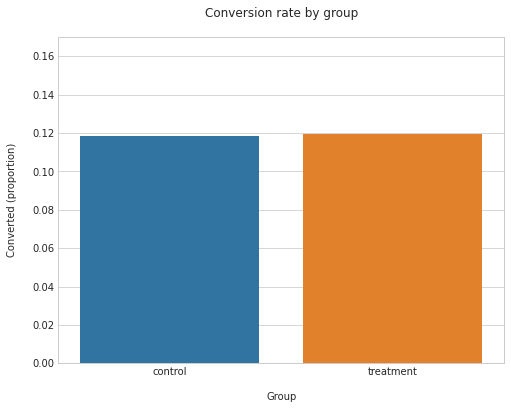

In [26]:

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);


The conversion rates for our groups are indeed very close. Also note that the conversion rate of the control group is lower than what we would have expected given what we knew about our avg. conversion rate (12.3% vs. 13%). This goes to show that there is some variation in results when sampling from a population.

So... the treatment group's value is higher. Is this difference statistically significant?

4. Testing the hypothesis
The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the normal approximation for calculating our $p$-value (i.e. z-test).

Again, Python makes all the calculations very easy. We can use the statsmodels.stats.proportion module to get the $p$-value and confidence intervals:

In [27]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [28]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [29]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.10
p-value: 0.924
ci 95% for control group: [0.109, 0.128]
ci 95% for treatment group: [0.110, 0.129]



Since our $p$-value=0.732 is way above our $\alpha$=0.05, we cannot reject the null hypothesis $H_0$, which means that our new design did not perform significantly different (let alone better) than our old one :(

Additionally, if we look at the confidence interval for the treatment group ([0.116, 0.135], i.e. 11.6-13.5%) we notice that:

It includes our baseline value of 13% conversion rate
It does not include our target value of 15% (the 2% uplift we were aiming for)
What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!